# Libraries

In [1]:
# Funciones caseras para estandarizar la computación
#from Functions import *
# Para el acceso a los ficheros
import os
# Para las imágenes
import numpy as np
import cv2 # OpenCV-Python
%matplotlib inline
import matplotlib.pyplot as plt
# Para controlar el tiempo
import time

In [2]:
data_path = "../Circuito_Almeria_171021/Iniciados/Data_resized/"

In [4]:
ratio = 0.8

training_data = []
test_data = []
classes = []
start_time = time.time()
for folder in os.listdir(data_path):
    counter_training_samples = 0
    counter_test_samples = 0
    for file in os.listdir(data_path + folder):
        if not (file.startswith("C")):
            img = cv2.imread(data_path + folder + "/" + file)
            if counter_training_samples <= ratio*len(os.listdir(data_path + folder))/2:
                training_data.append(img)
                classes.append(int(folder))
                counter_training_samples += 1
            else:
                test_data.append(img)
                counter_test_samples += 1
    print(str(counter_training_samples) + " traning images read -> " + folder)
    print(str(counter_test_samples) + " test images read -> " + folder)
print('Elapsed time: %.6fs' % (time.time() - start_time))

73 traning images read -> 1
17 test images read -> 1
49 traning images read -> 10
11 test images read -> 10
68 traning images read -> 11
16 test images read -> 11
53 traning images read -> 12
12 test images read -> 12
53 traning images read -> 13
13 test images read -> 13
64 traning images read -> 14
15 test images read -> 14
57 traning images read -> 15
13 test images read -> 15
65 traning images read -> 16
16 test images read -> 16
53 traning images read -> 17
12 test images read -> 17
59 traning images read -> 18
14 test images read -> 18
41 traning images read -> 19
10 test images read -> 19
86 traning images read -> 2
21 test images read -> 2
25 traning images read -> 20
5 test images read -> 20
60 traning images read -> 21
14 test images read -> 21
81 traning images read -> 22
20 test images read -> 22
70 traning images read -> 23
17 test images read -> 23
77 traning images read -> 24
18 test images read -> 24
65 traning images read -> 25
16 test images read -> 25
81 traning imag

In [5]:
training_data_reshaped = np.reshape(training_data, (len(training_data), 182*273*3))

training_data_array = np.asarray(training_data_reshaped, np.float32)

classes = np.array(classes)

In [5]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(training_data_array)

PCA()

(0.0, 0.05)

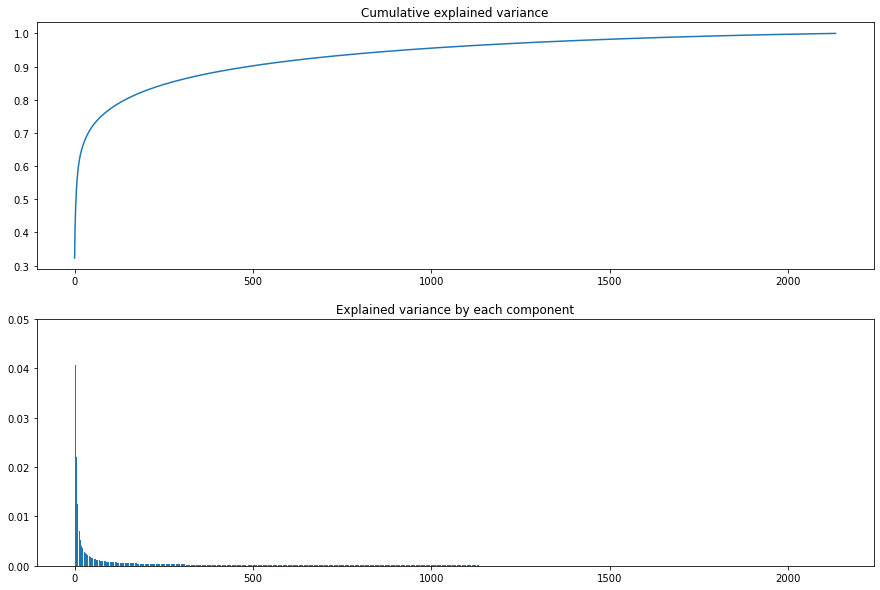

In [6]:
cumsum=np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(cumsum)
plt.title('Cumulative explained variance')
plt.subplot(2,1,2)
#El aporte de cada autovalor a la suma total, nos muestra la varianza explicada por cada componente
plt.bar(range(pca.explained_variance_ratio_.shape[0]), pca.explained_variance_ratio_)
plt.title('Explained variance by each component')
plt.ylim(0,0.05)

In [21]:
desired_percentage_variance_explained = 0.90
print("At least " + str(np.where(cumsum >= desired_percentage_variance_explained)[0][0]) + 
      " components are required to explain " + str(desired_percentage_variance_explained*100) + 
      "% of the variance")

At least 1712 components are required to explain 99.0% of the variance


In [22]:
pca = PCA(n_components = np.where(cumsum >= desired_percentage_variance_explained)[0][0])
training_data_array_pca = pca.fit_transform(training_data_array)

In [9]:
def trainAuto_Linear(training_data, classes, kfold = 10, minC = None, maxC = None, logStepC = None):
    """
        Entrena el clasificador SVM lineal hiperparametrizándolo.
        Si no se especifican valores para las mallas se usan las mallas por defecto de cada parámetro.

        Parameters:
        training_data(np.array): datos de entrenamiento
        classes(np.array): clases asociadas a los datos de entrenamiento
        kfold(int): número de particiones en la validación cruzada
        minC(float32): mínimo C en el grid
        maxC(float32): máximo C en el grid
        logStepC(float32): factor logaritmico de C en el grid

        Returns:
        (cv2.SVM): un clasificador SVM
    """
    
    # DECLARACIÓN DEL MODELO
    svm = cv2.ml.SVM_create()
    svm.setType(cv2.ml.SVM_C_SVC)
    # SE ESTABLECE EL KERNEL
    svm.setKernel(cv2.ml.SVM_LINEAR)
    
    # SE CREAN LAS MALLAS DE PARÁMETROS
    CGrid = cv2.ml.SVM_getDefaultGridPtr(0) if ((minC is None) & (maxC is None) & (logStepC is None)) else cv2.ml.ParamGrid_create(minC, maxC, logStepC)
    
    # SE ENTRENA E HIPERPARAMETRIZA EL MODELO USANDO LAS MALLAS
    svm.trainAuto(training_data, cv2.ml.ROW_SAMPLE, classes,
                kFold = kfold,
                Cgrid = CGrid,
                balanced = False 
                )
    
    return svm

In [23]:
start_time = time.time()
clasificador_linear = trainAuto_Linear(training_data_array_pca, classes, kfold = 2)
print('Elapsed time: %.6fs' % (time.time() - start_time))
print("Clasificador Lineal entrenado")

Elapsed time: 19.355407s
Clasificador Lineal entrenado


In [24]:
# Se muestra el resultado de la hiperparametrización
print("C: " + str(clasificador_linear.getC()))

C: 0.1


In [25]:
def build_k_indices(y, k_fold, seed):
    """
    build k indices for k-fold.
    
    Parameters:
    y(np.array): datos de entrenamiento
    kfold(int): número de particiones en la validación cruzada
    seed(float32): semilla de aleatoriedad

    Returns:
    k_indices(list of np.array): índices de las k-fold particiones
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def test_model(model, training_data, classes, kfold = 10):
    """
    Extrae del modelo hiperparametrizado los parametros y ejecuta con el mismo modelo usando todo el conjunto de datos de entrenamiento una validación cruzada de la que se obtiene el Accuracy
    
    Parameters: 
        model(cv2.SVM): modelo
        training_data(np.array): datos de entrenamiento
        classes(np.array): clases asociadas a los datos de entrenamiento
        kfold(int): número de particiones en la validación cruzada
        
    Returns:
        (float32): Accuracy del modelo
    """
    
    # SE CREA EL MODELO SVM Y SE ESTABLECEN LOS PARAMETROS DEL MODELO INTRODUCIDO
    svm = cv2.ml.SVM_create()
    svm.setType(cv2.ml.SVM_C_SVC)
    svm.setKernel(model.getKernelType())
    svm.setC(model.getC())
    svm.setGamma(model.getGamma())
    svm.setCoef0(model.getCoef0())
    svm.setDegree(model.getDegree())
    
    # SE CREAN LOS INDICES DE LAS PARTICIONES
    k_indices = build_k_indices(training_data, kfold, seed = 42)
    
    # SE DECLARA LA VARIABLE DONDE SE GUARDAN LOS RESULTADOS DEL RENDIMIENTO
    accuracies = list()
    
    # PARA CADA PARTICIÓN
    for i in range(0, len(k_indices)):
        # SE GUARDAN LOS DATOS DE ENTRENAMIENTO RELATIVOS A DICHA PARTICIÓN
        test_data_cv = training_data[k_indices[i]]
        test_classes_cv = classes[k_indices[i]]
        training_data_cv = np.delete(training_data, k_indices[i], 0)
        training_classes_cv = np.delete(classes, k_indices[i])
        # SE ENTRENA EL MODELO CON LOS DATOS DE ENTRENAMIENTO DE LA PARTICIÓN
        svm.train(training_data_cv, cv2.ml.ROW_SAMPLE, training_classes_cv)
        # SE GUARDAN LAS PREDICCIONES DEL MODELO PARA EL CONJUNTO DE TEST
        predicted_test_classes_cv = svm.predict(test_data_cv)
        # SE COMPARAN LAS PREDICCIONES CON EL VALOR REAL
        accuracy = np.sum(np.reshape(predicted_test_classes_cv[1], (-1)) == test_classes_cv)/len(test_classes_cv)
        # SE GUARDAN LOS RESULTADOS
        accuracies.append(accuracy)
    
    return np.mean(accuracies)

In [26]:
accuracy_linear_pca = test_model(clasificador_linear, training_data_array_pca, classes)

In [27]:
print("Accuracy of Linear SVM using PCA= " + str(round(accuracy_linear_pca * 100, 2)) + " %")

Accuracy of Linear SVM using PCA= 23.52 %


In [30]:
print("The performance is " + str(round(accuracy_linear_pca*34, 2)) + " times better than random")

The performance is 8.0 times better than random
